Лабораторная работа 1

Тема: О росте больных ковидом

Вариант 3. Данные с мая.

Задание.
Возьмите открытые данные о росте числа зараженных COVID-19 в мире за три месяца. Первый месяц из трех определяется сдвигом на номер по списку с февраля 2020 года. Проверьте гипотезу о том, что этот рост описывается экспоненциальной функцией. Полученное р-значение сравните с уровнем значимости 0,05.

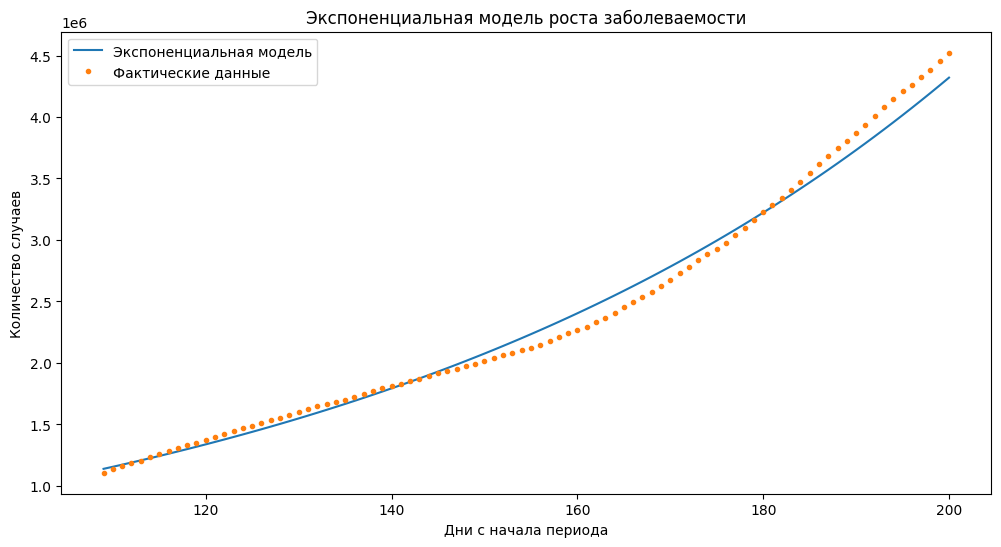

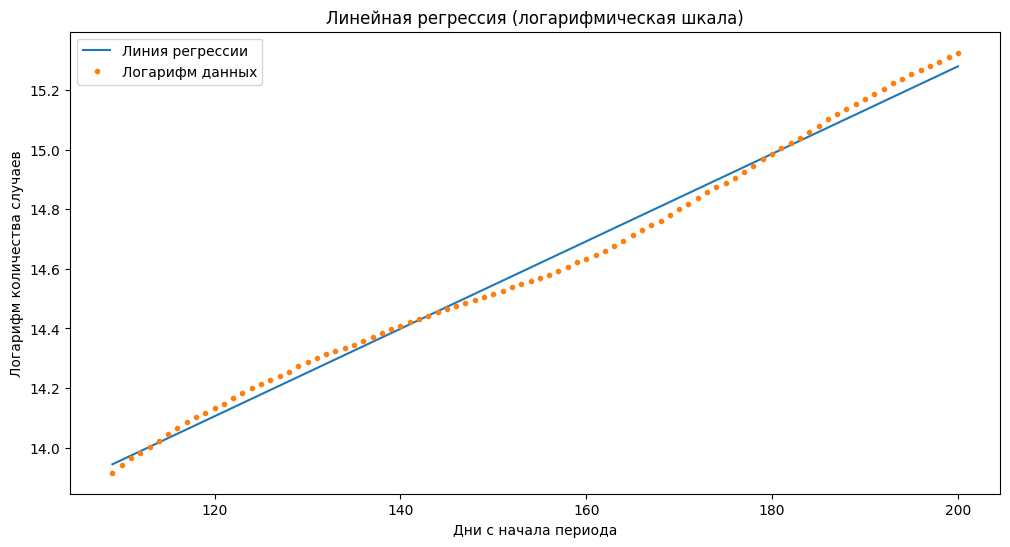

Коэффициент корреляции Пирсона: K = 0.9962137715442937, p-value = 2.8434643476941276e-97

Оценка адекватности модели:
Статистика хи-квадрат: K = 14.477029076503012, p-value = 0.024738470882016146
Гипотеза отвергается, K > G (14.477029076503012 > 11.07)


In [11]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Константы
NUM_BINS = 8  # Количество интервалов для гистограммы
CRITICAL_VALUE = 11.07  # Критическое значение для критерия хи-квадрат

# Загрузка и подготовка данных
def load_and_prepare_data(filepath):
    """Загружает данные из CSV файла, обрабатывает и фильтрует их"""
    # Чтение данных с переворотом порядка строк (исходные данные в обратном хронологическом порядке)
    df = pd.read_csv(filepath, sep=',')
    df = df.iloc[::-1].reset_index(drop=True)

    # Преобразование даты и фильтрация по периоду
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df.loc[(df['date'] >= '2020-05-01') & (df['date'] < '2020-08-01')]

    # Выбор нужных столбцов и добавление логарифма положительных случаев
    df = df[["date", "positive"]]
    df["log_positive"] = np.log(df["positive"])

    return df

# Анализ данных и построение графиков
def analyze_and_plot(df):
    """Выполняет линейную регрессию и строит графики"""
    # Линейная регрессия для логарифма положительных случаев
    slope, intercept = np.polyfit(df.index.values, df["log_positive"], 1)

    # Расчет коэффициента корреляции Пирсона
    pearson_r, p_value = scipy.stats.pearsonr(
        df["log_positive"],
        [slope * idx + intercept for idx in df.index.values]
    )

    # График 1: Экспоненциальная модель и фактические данные
    plt.figure(figsize=(12, 6))
    plt.title("Экспоненциальная модель роста заболеваемости")
    plt.xlabel("Дни с начала периода")
    plt.ylabel("Количество случаев")

    x_values = df.index.values
    plt.plot(x_values, np.exp(slope * x_values + intercept),
             x_values, df["positive"], ".")
    plt.legend(["Экспоненциальная модель", "Фактические данные"])
    plt.show()

    # График 2: Линейная регрессия в логарифмической шкале
    plt.figure(figsize=(12, 6))
    plt.title("Линейная регрессия (логарифмическая шкала)")
    plt.xlabel("Дни с начала периода")
    plt.ylabel("Логарифм количества случаев")

    plt.plot(x_values, slope * x_values + intercept,
             x_values, df["log_positive"], ".")
    plt.legend(["Линия регрессии", "Логарифм данных"])
    plt.show()

    return slope, intercept, pearson_r, p_value

# Проверка адекватности модели
def check_model_adequacy(df, slope, intercept):
    """Проверяет адекватность модели с помощью критерия хи-квадрат"""
    # Расчет остатков (разница между фактическими и предсказанными значениями)
    df["residuals"] = df["log_positive"] - (slope * df.index.values + intercept)

    # Дисперсия остатков
    df["residuals_variance"] = (df["residuals"] - df["residuals"].mean()) ** 2
    std_deviation = df["residuals_variance"].mean() ** 0.5

    # Разбиение остатков на интервалы для критерия хи-квадрат
    min_residual = min(df["residuals"])
    max_residual = max(df["residuals"])

    # Создание интервалов для гистограммы
    bin_edges = [min_residual + i * (max_residual - min_residual) / NUM_BINS
                 for i in range(0, NUM_BINS + 1)]

    # Замена первого и последнего значения для включения бесконечности
    bin_edges[0] = -np.inf
    bin_edges[-1] = np.inf


    df['residual_bin'] = pd.cut(
        df["residuals"],
        bin_edges,
        labels=[i for i in range(0, NUM_BINS)]
    )

    # Эмпирические и ожидаемые частоты
    observed_freq = [df[df["residual_bin"] == i].count()["residual_bin"]
                     for i in range(0, NUM_BINS)]

    expected_freq = [
        ((scipy.stats.norm.cdf(bin_edges[i + 1] / std_deviation) -
          scipy.stats.norm.cdf(bin_edges[i] / std_deviation)) * len(df))
        for i in range(0, NUM_BINS)]


    # Критерий хи-квадрат
    chi2_stat, chi2_p = scipy.stats.chisquare(
        f_obs=observed_freq,
        f_exp=expected_freq,
        ddof=1 # Corrected df
    )

    return chi2_stat, chi2_p

# Основной поток выполнения
if __name__ == "__main__":
    # Загрузка данных
    data_filepath = '/content/drive/MyDrive/Colab Notebooks/national-history.csv'
    covid_data = load_and_prepare_data(data_filepath)

    # Анализ данных и построение графиков
    slope, intercept, pearson_r, p_value = analyze_and_plot(covid_data)
    print(f"Коэффициент корреляции Пирсона: K = {pearson_r}, p-value = {p_value}")

    # Проверка адекватности модели
    print("\nОценка адекватности модели:")
    chi2_stat, chi2_p = check_model_adequacy(covid_data, slope, intercept)
    print(f"Статистика хи-квадрат: K = {chi2_stat}, p-value = {chi2_p}")

    # Вывод результата проверки гипотезы
    if chi2_stat > CRITICAL_VALUE:
        print(f"Гипотеза отвергается, K > G ({chi2_stat} > {CRITICAL_VALUE})")
    else:
        print(f"Гипотеза подтвердилась, K < G ({chi2_stat} < {CRITICAL_VALUE})")

Линейная зависимость в логарифмической шкале действительно наблюдается, о чём свидетельствует:

Коэффициент корреляции Пирсона, близкий к 1 (K = 0.996)

Крайне низкое p-значение (p < 2.84·10⁻⁹⁷), подтверждающее статистическую значимость линейной связи между временем и логарифмом количества случаев.

Проверка адекватности экспоненциальной модели с использованием критерия хи-квадрат показала:

Рассчитанное значение статистики χ² = 14.477.

p-value = 0.0247.

Вывод: Данные демонстрируют сильную линейную зависимость в логарифмической шкале, что характерно для экспоненциального роста. Критическое значение критерия хи-квадрат при 5 степенях свободы и уровне значимости α = 0.05 составляет 11.07. Поскольку рассчитанное значение статистики χ² (14.477) превышает критическое значение (11.07), или, что эквивалентно, p-value (0.0247) меньше принятого уровня значимости α = 0.05, гипотеза о том, что экспоненциальная модель адекватно описывает данные, отвергается. Это означает, что распределение остатков существенно отличается от ожидаемого, и простая экспоненциальная модель недостаточно точно описывает динамику распространения COVID-19 на рассматриваемом временном интервале. Возможно, требуется более сложная модель, учитывающая, например, ограничения на распространение вируса или другие факторы, влияющие на динамику заболеваемости.